# Problem 1
A static map of cycling accidents in Finland. A choropleth map.

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point


In [2]:
# Import the data, select columns that are needed
fp ="data/tieliikenneonnettomuudet_2019_onnettomuus.csv"
data = pd.read_csv(fp, delimiter=";", usecols=["Onnett_id", "X", "Y", "Vakavuusko", "Vakavuus", "Onluokka", "Kuntasel", "Ontyyppi", "Ontyypsel"])

# Import population data
fp_pop = "data/vaesto_2019.shp"
pop = gpd.read_file(fp_pop)

In [3]:
pop.head()

,kunta,nimi,namn,vaesto,vaesto_p,miehet,miehet_p,naiset,naiset_p,ika_0_14,ika_0_14p,ika_15_64,ika_15_64p,ika_65_,ika_65_p,geometry
0,005,Alajärvi,Alajärvi,9562,0.2,4846,50.7,4716,49.3,1661,17.4,5230,54.7,2671,27.9,"POLYGON ((366787.924 7001300.583, 362458.797 6..."
1,046,Enonkoski,Enonkoski,1361,0.0,705,51.8,656,48.2,156,11.5,690,50.7,515,37.8,"POLYGON ((600317.407 6904777.746, 599646.150 6..."
2,271,Kokemäki,Kumo,7103,0.1,3543,49.9,3560,50.1,908,12.8,4028,56.7,2167,30.5,"POLYGON ((264362.048 6804367.733, 256997.760 6..."
3,272,Kokkola,Karleby,47681,0.9,23555,49.4,24126,50.6,8968,18.8,28108,59.0,10605,22.2,"POLYGON ((333145.547 7108319.325, 340750.179 7..."
4,273,Kolari,Kolari,3846,0.1,1945,50.6,1901,49.4,578,15.0,2245,58.4,1023,26.6,"POLYGON ((384193.776 7503812.015, 390932.096 7..."


<AxesSubplot:>

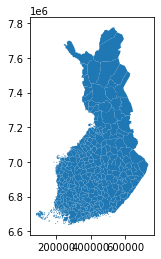

In [4]:
# Save a basemap for plotting
finland = pop[["geometry"]]
finland.plot()

In [5]:
# Extract the cycling accident from the data
cycling = data.loc[data["Onluokka"]==8]

# Group the cycling accident data by municipalities
cycling = cycling.groupby("Kuntasel")["Onnett_id"].count()


In [6]:
# Merge the accident data to municipalities
pop = pop.merge(cycling, how="inner", left_on="nimi", right_on="Kuntasel")


In [7]:
# REname accident count column
pop.rename(columns={"Onnett_id":"accidents"}, inplace=True)

In [8]:
pop["acc_100000"] = pop["accidents"]/pop["vaesto"]*100000
pop.head()

,kunta,nimi,namn,vaesto,vaesto_p,miehet,miehet_p,naiset,naiset_p,ika_0_14,ika_0_14p,ika_15_64,ika_15_64p,ika_65_,ika_65_p,geometry,accidents,acc_100000
0,272,Kokkola,Karleby,47681,0.9,23555,49.4,24126,50.6,8968,18.8,28108,59.0,10605,22.2,"POLYGON ((333145.547 7108319.325, 340750.179 7...",15,31.459072
1,276,Kontiolahti,Kontiolahti,14821,0.3,7550,50.9,7271,49.1,3177,21.4,9101,61.4,2543,17.2,"POLYGON ((649790.562 6991216.563, 649880.827 6...",2,13.494366
2,285,Kotka,Kotka,52126,0.9,25747,49.4,26379,50.6,6935,13.3,31145,59.7,14046,26.9,"MULTIPOLYGON (((511055.967 6682334.505, 510156...",15,28.776426
3,286,Kouvola,Kouvola,82113,1.5,40385,49.2,41728,50.8,10946,13.3,48159,58.6,23008,28.0,"POLYGON ((511075.037 6780901.795, 512322.995 6...",20,24.356679
4,297,Kuopio,Kuopio,119282,2.2,58046,48.7,61236,51.3,17481,14.7,76420,64.1,25381,21.3,"POLYGON ((581015.594 7009316.911, 585462.344 7...",10,8.383495


In [9]:
# Select only the data that is needed
pop = pop[["nimi", "geometry", "acc_100000"]]

<AxesSubplot:ylabel='Frequency'>

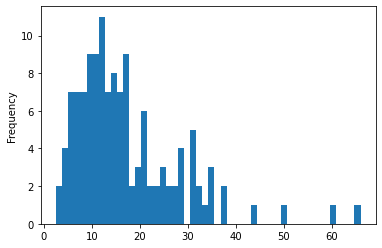

In [10]:
# Check the histogram
pop['acc_100000'].plot.hist(bins=50)

There are some municipalities with a lot of accidents/people. These are small municipalities so  even a small number of accidents rises the value hight.

In [11]:
# Use function from geopandas for the task
#cycling_geo = gpd.GeoDataFrame(
#    cycling, geometry=gpd.points_from_xy(cycling.X, cycling.Y))

# Set the crs for the gdf
#cycling_geo.crs = CRS.from_epsg(3067)

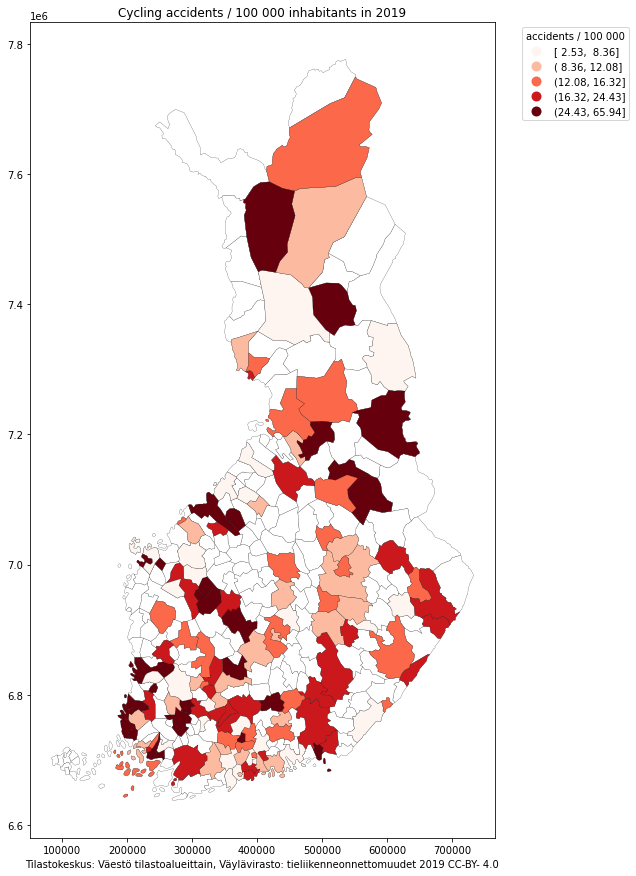

In [12]:
fig, ax = plt.subplots(figsize=(10,15))

credits="Tilastokeskus: Väestö tilastoalueittain, Väylävirasto: tieliikenneonnettomuudet 2019 CC-BY- 4.0"
output_fig = "cycling_accidents.png"

# Put empty map to the back to show all municipalities
finland.plot(ax=ax,
             color="white",
             linewidth=0.2,
             edgecolor="k")

# Plot the data
pop.plot(ax=ax,
            column="acc_100000",
            #scheme="Natural_breaks",
            scheme="Quantiles",
            cmap="Reds",
            legend=True,
            linewidth=0.2,
            edgecolor = "k",
           )

# Set title and set legend place
ax.get_legend().set_title("accidents / 100 000")
ax.get_legend().set_bbox_to_anchor((1.3,1))
#plt.tight_layout()

# Set title
ax.set_title("Cycling accidents / 100 000 inhabitants in 2019")

# Use x-label for showing credits
ax.set_xlabel(credits)


plt.savefig(output_fig, dpi=300)


In [13]:

# Save the image
#plt.savefig(output_fig, dpi=300)
